# Applying ICA / NMF to AOCS Ovarian Cancer gene expression

In [1]:
from os import path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import NMF, FastICA, PCA
from sklearn.manifold import TSNE
import statsmodels.formula.api as sm
import pickle
import mygene
import qgrid
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(10,6)})

In [3]:
def example_V(n_genes=100):
    # Generate example expression matrix, useful in tests
    np.random.seed(0)
    time = np.linspace(0, 8, n_genes)

    s1 = np.sin(time) + 1.1  # Signal 1 : sinusoidal signal
    s2 = np.sign(np.sin(3 * time)) + 1.1  # Signal 2: square signal
    s3 = np.sin(2 * np.pi * time) + 1.1  # Signal 3: saw tooth signal
    s4 = np.cos(0.5 * np.pi * time) + 1.1  # Signal 4: cosine
    s5 = np.sin(0.2 * np.pi * time) + 1.1  # Signal 5: higher freq sine

    W = np.c_[s1, s2, s3, s4, s5]
    W += 0.1 * np.random.normal(size=W.shape)  # Add noise

    W /= W.std(axis=0)  # Standardize data
    # Mix data
    H = np.array([[1, 1, 1, 1, 1], [0.5, 0/6, 1, 1.2, 1], [1.5, 1, 2, 1, 1.1],
                 [1, 0.4, 1, 1.1, 0.1], [1, 0.2, 0.8, 1, 1.5]])  # Mixing matrix
    V = np.dot(W, H.T)  # Generate observations
    return V

def test_example_V():
    ngenes = 10
    eg_V = example_V(ngenes)
    # print(eg_V.shape)
    # print(eg_V)
    assert eg_V.shape == (10, 5)
    assert np.all(eg_V >= 0)
    print("test_example_V() passed.")
    
test_example_V()

test_example_V() passed.


In [4]:
# Make wrapper classes for FastICA and NMF, so we can interface to them identically
class ICA_Factorizer(FastICA):
    def __init__(self, n_components=None, max_iter=200, 
                 random_state=42, fun='logcosh'):
        FastICA.__init__(self, n_components=n_components, max_iter=max_iter,
                        random_state=random_state, fun=fun)
        self.V = None
        self.W = None
        self.H = None
        self.recovered_V = None
        
    def fit(self, V):
        self.V = V
        self.W = self.fit_transform(V)
        return self
        
    def get_W(self):
        assert self.V is not None
        if self.W is None:
            self.W = self.fit_transform(self.V)
        return self.W
    
    def get_H(self):
        assert self.V is not None
        if self.H is None:
            self.H = self.mixing_.T
        return self.H
    
    def get_recovered_V(self):
        assert self.V is not None
        if self.recovered_V is None:
            W = self.get_W()
            H = self.get_H()
            mean = self.mean_
            self.recovered_V = np.dot(W, H) + mean
            #print(self.recovered_V)
        return self.recovered_V

def test_Factorizer(facto, atol):
    print(facto)
    V = example_V(10)
    
    facto.fit(V)
    
    W = facto.get_W()
    assert W.shape == (V.shape[0], facto.n_components)
    
    H = facto.get_H()
    assert H.shape == (facto.n_components, V.shape[1])
    
    V2 = facto.get_recovered_V()
    assert np.allclose(V, V2, atol=atol)
        
    print("test_Factorizer (%s) passed" % type(facto).__name__)
    
test_Factorizer(ICA_Factorizer(n_components=4), atol=0.5) 
test_Factorizer(ICA_Factorizer(n_components=5), atol=0.001) 

ICA_Factorizer(n_components=4)
test_Factorizer (ICA_Factorizer) passed
ICA_Factorizer(n_components=5)
test_Factorizer (ICA_Factorizer) passed


In [5]:
class NMF_Factorizer(NMF):
    def __init__(self, n_components=None, max_iter=200, random_state=42):
        NMF.__init__(self, n_components=n_components, max_iter=max_iter, 
                     random_state=random_state)
        self.V = None
        self.W = None
        self.H = None
        self.recovered_V = None
        
    def fit(self, V):
        self.V = V
        self.W = self.fit_transform(V)
        return self
        
    def get_W(self):
        assert self.V is not None
        if self.W is None:
            self.W = self.fit_transform(self.V)
        return self.W
    
    def get_H(self):
        assert self.V is not None
        if self.H is None:
            self.H = self.components_
        return self.H
    
    def get_recovered_V(self):
        assert self.V is not None
        if self.recovered_V is None:
            W = self.get_W()
            H = self.get_H()
            self.recovered_V = np.dot(W, H)
            #print(self.recovered_V)
        return self.recovered_V

test_Factorizer(NMF_Factorizer(n_components=4), atol=1) 
test_Factorizer(NMF_Factorizer(n_components=5), atol=0.2) 

NMF_Factorizer(n_components=4)
test_Factorizer (NMF_Factorizer) passed
NMF_Factorizer(n_components=5)
test_Factorizer (NMF_Factorizer) passed


In [6]:
class PCA_Factorizer(PCA):
    def __init__(self, n_components=None, max_iter=None, random_state=None):
        PCA.__init__(self, n_components=n_components)
        self.V = None
        self.W = None
        self.H = None
        self.recovered_V = None
        
    def fit(self, V):
        self.V = V
        self.W = self.fit_transform(V)
        return self
        
    def get_W(self):
        assert self.V is not None
        if self.W is None:
            self.W = self.fit_transform(self.V)
        return self.W
    
    def get_H(self):
        assert self.V is not None
        if self.H is None:
            self.H = self.components_
        return self.H
    
    def get_recovered_V(self):
        assert self.V is not None
        if self.recovered_V is None:
            W = self.get_W()
            H = self.get_H()
            self.recovered_V = np.dot(W,H) + self.mean_
        return self.recovered_V


test_Factorizer(PCA_Factorizer(n_components=4), atol=1) 
test_Factorizer(PCA_Factorizer(n_components=5), atol=0.001) 

PCA_Factorizer(n_components=4)
test_Factorizer (PCA_Factorizer) passed
PCA_Factorizer(n_components=5)
test_Factorizer (PCA_Factorizer) passed


### Matrix plotting utility

In [7]:
def l2_norm_diff(m1, m2):
#   return np.mean(np.sqrt((m1 - m2)**2))
    return np.sqrt(np.mean((m1 - m2)**2))

def test_l2_norm_diff():
    V = example_V(10)
    rms = l2_norm_diff(V, V+0.5)
    assert np.isclose(rms,0.5)
    
test_l2_norm_diff() 

v.shape (10, 5)
H.shape (2, 5)


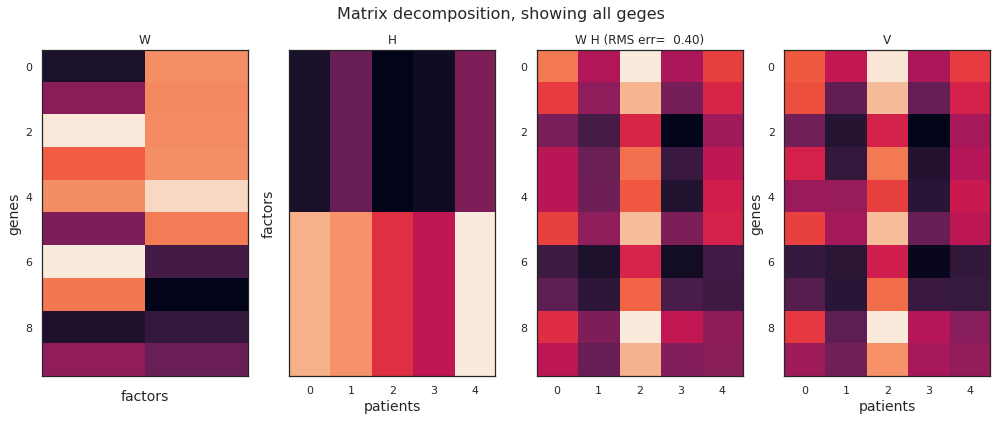

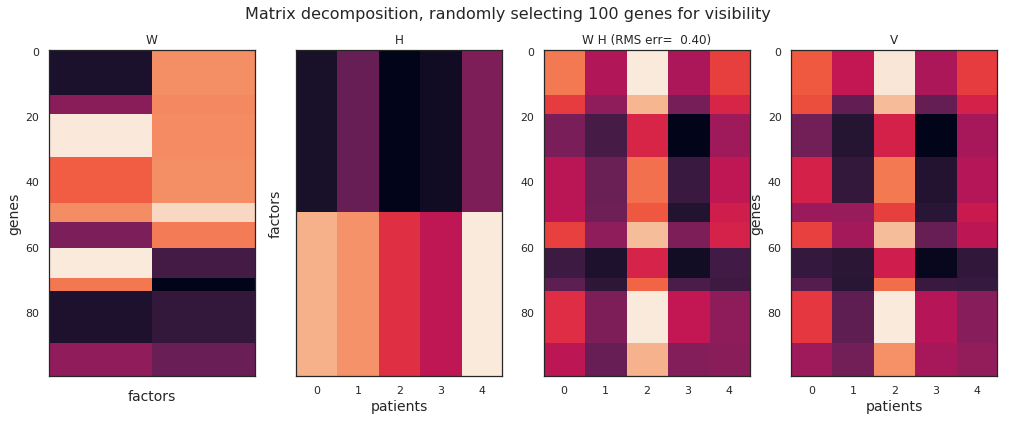

In [8]:
def show_W_H_WH_V(W, H, V, rec_V, n_genes_to_pick=None):
    """ Show factorization matrices in visually pleasing form"""
    
    if n_genes_to_pick is None:
        gene_ixs = range(V.shape[0])
        title = "Matrix decomposition, showing all geges"
    else:
        gene_ixs = sorted(np.random.randint(0, V.shape[0], n_genes_to_pick))
        title = "Matrix decomposition, randomly selecting %d genes for visibility" % n_genes_to_pick
    fig, axs = plt.subplots(1,4, figsize=(17,6))
    fig.suptitle(title, size=16)
    axs[0].imshow(W[gene_ixs,:], aspect='auto')
    axs[0].set_title('W')
    axs[0].set_ylabel('genes', size=14)
    axs[0].set_xlabel('factors', size=14)
    
    axs[0].set_xticklabels('')
    
    axs[1].imshow(H, aspect='auto')
    axs[1].set_title('H')
    axs[1].set_ylabel('factors', size=14)
    axs[1].set_xlabel('patients', size=14)
    axs[1].set_yticklabels('')
    
    rms_err = l2_norm_diff(rec_V, V)
    axs[2].imshow(rec_V[gene_ixs,:], aspect='auto')
    axs[2].set_title('W H (RMS err=%6.2f)' % rms_err)
   
    
    axs[3].imshow(V[gene_ixs,:], aspect='auto')
    axs[3].set_title('V')
    axs[3].set_ylabel('genes', size=14)
    axs[3].set_xlabel('patients', size=14)

    plt.show()

def test_show_W_H_WH_V():
    
    V = example_V(10)
    print("v.shape", V.shape)
    facto = ICA_Factorizer(n_components=2)
    facto.fit(V)
    W = facto.get_W()
    H = facto.get_H()
    print("H.shape", H.shape)
    
    show_W_H_WH_V(W,H, V, facto.get_recovered_V())
    show_W_H_WH_V(W,H,V, facto.get_recovered_V(), 100)
test_show_W_H_WH_V()    


## Read and explore the expression matrix

In [9]:
# Read in expression spreadsheet which has been processed (see end of notebook) to inlcude only protein coding genes
expression_df = pd.read_csv('../Data/HGSOC_Protein_Expression.csv', sep='\t')
expression_df.set_index('GeneENSG', inplace=True)
assert len(expression_df) == 19730   # Only 
assert len(expression_df.columns) == 80
assert expression_df.columns[-1] == 'AOCS_171'

expression_matrix = np.asarray(expression_df)

print(expression_matrix.shape[0], "genes")
print(expression_matrix.shape[1], "patients")

19730 genes
80 patients


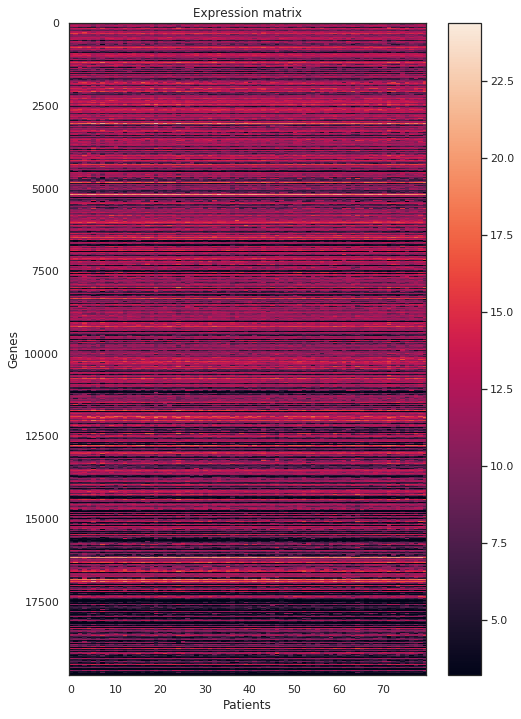

In [10]:
plt.figure(figsize=(8, 12))
plt.imshow(expression_matrix, aspect='auto')
plt.colorbar()
plt.xlabel(("Patients"))
plt.ylabel(("Genes"))
plt.title("Expression matrix")
plt.show()

## Construct a dictionary to map Ensembl ENSG ids to symbols

In [11]:
# This is run-once code to query for all the Ensemble gene IDs we're using, construct a dictionary and write
# it to file.

ensgDictFile = '../Cache/ensgDict.pkl'
if not path.exists(ensgDictFile):  # Run only if dictionary file does not already exist
    mg = mygene.MyGeneInfo()
    ensgIDs = expression_df.index.values.tolist()    # All the gene IDs in this study
    ginfo = mg.querymany(ensgIDs, scopes='ensembl.gene')

    ensgDict = {}
    for g in ginfo:
        ensg = g['query']
        del g['query'] 
        ensgDict[ensg] = g

    print("Writing to %s..." % ensgDictFile)
    with open(ensgDictFile, 'wb') as f:
        pickle.dump(ensgDict, f)
    print("Done.")


In [12]:
# Read the gene dictionary file
with open(ensgDictFile, 'rb') as f:
    ensgDict = pickle.load(f)
    
for (ensg, g) in ensgDict.items():
    if 'symbol' not in g.keys():
        g['symbol'] = ensg    # ensure lookup always succeeds
    
# Example use:
def example_ensgDict_use():
    gid = 'ENSG00000000938'
    # All ENSG ids used in this study should be in the dictionary
    ginfo = ensgDict[gid]
              
example_ensgDict_use()
    

## Note prior normalisation of the expression array
Normalisation was applied by Ailith's script, using the method of a varaince stabalising transform.  See below, all patients have a minimum of aproximately 3.5, maximum approaximately 23.

In [13]:
expression_df.describe()

,AOCS_001,AOCS_004,AOCS_005,AOCS_034,AOCS_055,AOCS_056,AOCS_057,AOCS_058,AOCS_059,AOCS_060,...,AOCS_161,AOCS_162,AOCS_163,AOCS_164,AOCS_165,AOCS_166,AOCS_168,AOCS_169,AOCS_170,AOCS_171
count,19730.000000,19730.000000,19730.000000,19730.000000,19730.000000,19730.000000,19730.000000,19730.000000,19730.000000,19730.000000,...,19730.000000,19730.000000,19730.000000,19730.000000,19730.000000,19730.000000,19730.000000,19730.000000,19730.000000,19730.000000
mean,9.488958,9.494032,9.503752,9.577368,9.568004,9.341342,9.531659,9.314278,9.449645,9.505443,...,9.494458,9.372473,9.394990,9.312501,9.464600,9.490979,9.433941,9.445837,9.501491,9.457069
std,3.609313,3.717080,3.513653,3.635960,3.581609,3.495206,3.478954,3.803839,3.664834,3.575270,...,3.445287,3.847070,3.484047,3.708698,3.445259,3.387385,3.442898,3.467571,3.545316,3.358251
min,3.207976,3.207976,3.207976,3.207976,3.207976,3.207976,3.207976,3.207976,3.207976,3.207976,...,3.207976,3.207976,3.207976,3.207976,3.207976,3.207976,3.207976,3.207976,3.207976,3.207976
25%,6.347711,6.075133,6.547224,6.452911,6.606901,6.484166,6.659206,6.250937,6.134030,6.361052,...,6.689324,5.944387,6.528378,5.911453,6.600077,6.968434,6.589921,6.451084,6.448284,7.106223
50%,10.450413,10.464928,10.361712,10.489850,10.441330,9.954817,10.417586,9.932660,10.417197,10.353428,...,10.431566,10.056516,10.142367,10.166874,10.350265,10.192455,10.308707,10.329499,10.414521,9.945322
75%,12.238497,12.378666,12.169945,12.335997,12.262090,11.912770,12.137078,12.106994,12.278930,12.258765,...,12.131020,12.308753,11.984763,12.208683,12.121886,11.942769,12.030358,12.093641,12.210701,11.828008
max,23.938739,23.191228,23.918881,22.272548,24.011974,22.908584,23.120995,23.144337,23.631234,23.228671,...,22.297948,23.069532,22.450623,22.716559,23.112822,22.526332,23.290668,22.700932,23.418327,22.628676


## Plot distributions of expression data
... for a quick visual check.

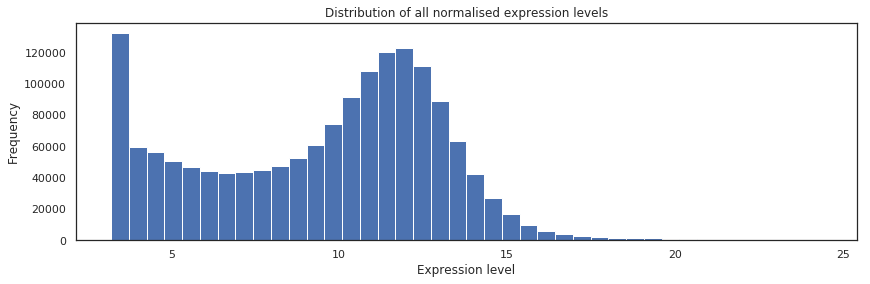

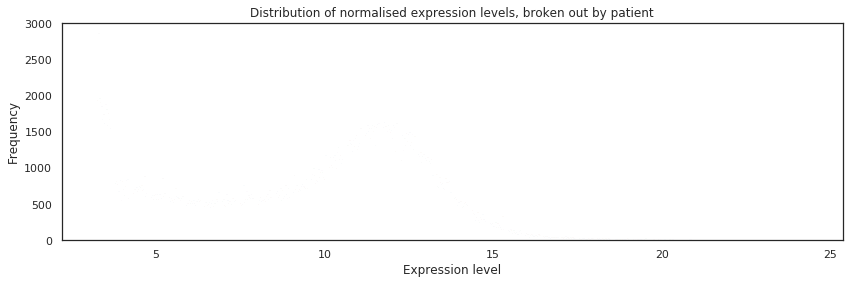

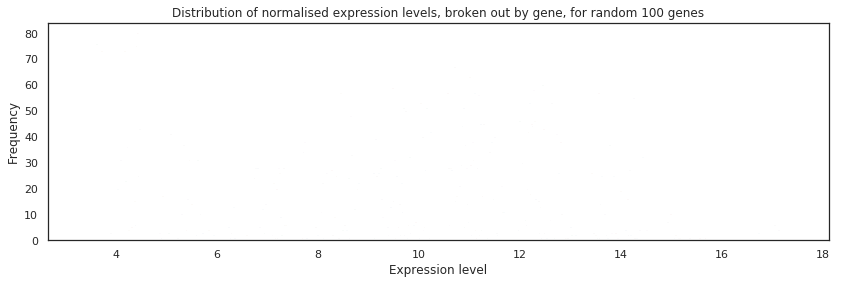

In [14]:
def show_expression_distributions(V):
    def labeled_figure():
        plt.figure(figsize=(14,4))
        plt.xlabel('Expression level')
        plt.ylabel('Frequency')
        
    if True:
        labeled_figure()
        _ = plt.hist(V.ravel(), bins=40)
        plt.title("Distribution of all normalised expression levels")
        plt.show()
    
    if True:
        labeled_figure()
        _ = plt.hist(V, bins=40)
        plt.title("Distribution of normalised expression levels, broken out by patient")
        plt.show()
        
    if True:
        labeled_figure()
        n_genes_to_pick = 100
        random_gene_ixs = sorted(np.random.randint(0, V.shape[0], n_genes_to_pick))
        _ = plt.hist(V[random_gene_ixs,:].T, bins=10)
        plt.title("Distribution of normalised expression levels, broken out by gene, for random %d genes" %
                  n_genes_to_pick)
        plt.show()
    
show_expression_distributions(expression_matrix)


## Read the patient metadata
In particular we are interested in treatment "Resposnse", which we scraped from the Patch paper (code at end of notebool).

In [15]:
# Read metadata (which we scraped from the Patch etal paper!)
metadata_df = pd.read_csv('../Data/AOCS_metadata.csv', index_col='AOCS_ID')
assert metadata_df.columns[0] == "Age"
assert metadata_df.columns[1] == "Response"
# Make sure the IDs match-up between the two dataframes
assert (all(metadata_df.index == expression_df.columns))
metadata_df['Response'].value_counts()

Resistant     37
Sensitive     31
Refractory    12
Name: Response, dtype: int64

In [16]:
qgrid.show_grid(metadata_df)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

## Use ICA, NMF and PCA factorization and plot stuff...

In [17]:
def fit_and_plot_model(V, met_df, facto, plot=True):

    facto.fit(V)
    W = facto.get_W()
    H = facto.get_H()

    # Show the factored matrices and compare the reconstruction with the original
    if plot:
        show_W_H_WH_V(W, H, V, facto.get_recovered_V(), n_genes_to_pick=200)
    
    plot_df = metadata_df.copy().drop('Age', axis=1)
    
    factors = ['Factor_%d'%i for i in range(facto.n_components)]
    for i in range(len(factors)):
        plot_df[factors[i]] = H[i, :]
    
    # Boxplots of H factors by Response
    if plot:
        plot_df.boxplot(column=factors, by='Response', fontsize=10, figsize=(14,4), layout=(1, facto.n_components))
        plt.show()    

    # Scatter plots of metagenes matrix - W - using Seaborne
    if plot:
        sns.pairplot(plot_df, hue='Response')
        plt.show()
        
    # Make a t-SNE plot
    if plot:
        tsne = TSNE(n_components=2, init='pca', random_state=42, n_jobs=7)
        Y = tsne.fit_transform(W)
        sns.scatterplot(Y[:,0], Y[:,1])
        plt.show()
    
    # Put together a dictionary or results
    
    results_dict = {}
    
    # Find factor which best explains response
    
    ols_results = [sm.ols(fact + '~ C(Response)', data=plot_df).fit() for fact in factors]
    rsqs = [res.rsquared for res in ols_results]
    results_dict['best_rsq'] = np.max(rsqs)
    results_dict['best_factor'] = np.argmax(rsqs)
    results_dict['rms_err'] = l2_norm_diff(V, facto.get_recovered_V())
    
    return results_dict

print("================== ICA ======================")
result = fit_and_plot_model(expression_matrix, metadata_df,     
                            ICA_Factorizer(n_components=14),
                            plot=False)

print("\n================== NMF ======================")
result = fit_and_plot_model(expression_matrix, metadata_df,     
                            NMF_Factorizer(n_components=14),
                            plot=False)

print("\n================== PCA ======================")
result = fit_and_plot_model(expression_matrix, metadata_df,     
                            PCA_Factorizer(n_components=14),
                            plot=False)

================== ICA ======================

================== NMF ======================


/home/ipoole/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)



================== PCA ======================


In [18]:
if False:
    facto=ICA_Factorizer(n_components=14)
    V = expression_matrix
    facto.fit(V)
    W = facto.get_W()
    H = facto.get_H()

    # Make a t-SNE plot
    tsne = TSNE(n_components=2, init='pca', random_state=42, n_jobs=7)
    Y = tsne.fit_transform(W)
    
    #response_dict = {'Sensitive':0, 'Refractory':1, 'Resistant':2}
    #colour = np.array([response_dict[r] for r in plot_df['Response']]).T
    sns.scatterplot(Y[:,0], Y[:,1])
    plt.show()

In [19]:
def retreive_or_generate_results1_df():
    # Explore results for ICA, NMP and PCA, generating a list of dictionaries
    resultsFile = '../Cache/results1.csv'
    if not path.exists(resultsFile):
        Factos = [ICA_Factorizer, NMF_Factorizer, PCA_Factorizer]
        results1 = []
        for nc in range(2,40,2):
            for random_state in [42, 345, 13, 235, 583]:
                for Facto in Factos:
                    params = {'n_components':nc, 'random_state':random_state}

                    facto = Facto(**params)
                    params['which'] = type(facto).__name__
                    print(params)
                    res = fit_and_plot_model(expression_matrix, metadata_df, facto, plot=False)
                    print(res)
                    results1.append({**params, **res})

        print("Writing results1.csv")
        results1_df = pd.DataFrame(results1)
        results1_df.to_csv('results1.csv')
        print("Done.")

    print("Reading", resultsFile)
    results1_df = pd.read_csv(resultsFile)
    results1_df = results1_df.drop(columns=['Unnamed: 0'])
    return results1_df

In [20]:
results1_df = retreive_or_generate_results1_df()
qgrid.show_grid(results1_df)
results1_df.columns

Reading ../Cache/results1.csv


Index(['best_factor', 'best_rsq', 'n_components', 'random_state', 'rms_err',
       'which'],
      dtype='object')

Reading ../Cache/results1.csv


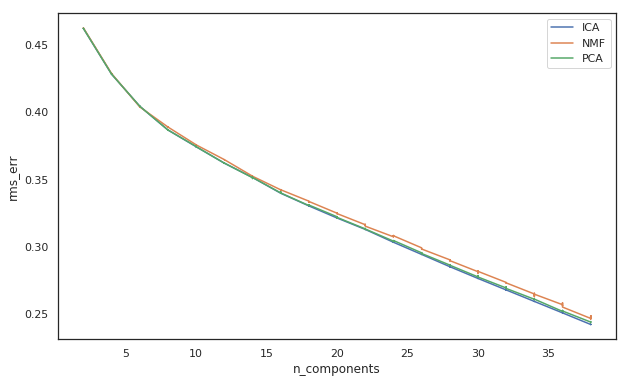

In [21]:
# Plot rms_err vs components for each method
results1_df = retreive_or_generate_results1_df()
for which in ["ICA_Factorizer", "NMF_Factorizer", "PCA_Factorizer"]:
    which_df = results1_df[results1_df['which']==which]
    x,y  = which_df['n_components'], which_df['rms_err']
    plt.plot(x,y, label=which[:3])
plt.legend()
plt.xlabel("n_components")
plt.ylabel("rms_err")
plt.show()


Reading ../Cache/results1.csv


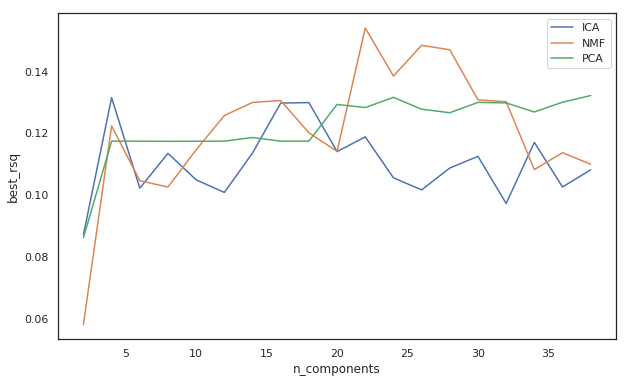

In [22]:
# Plot best_rsq fit to response vs components for each method
results1_df = retreive_or_generate_results1_df()
for which in ["ICA_Factorizer", "NMF_Factorizer", "PCA_Factorizer"]:
    which_df = results1_df[results1_df['which']==which]
    which_df = which_df.groupby('n_components').mean()
    x,y  = which_df.index, which_df['best_rsq']
    plt.plot(x,y, label=which[:3])
plt.legend()
plt.xlabel("n_components")
plt.ylabel("best_rsq")
plt.show()

In [23]:
which_df = results1_df[results1_df['which']==which]
which_df.groupby('n_components').mean()

,best_factor,best_rsq,random_state,rms_err
n_components,,,,
2,0.0,0.086183,243.6,0.462290
4,3.0,0.117460,243.6,0.428311
6,3.0,0.117459,243.6,0.404474
8,3.0,0.117422,243.6,0.386886
10,3.0,0.117442,243.6,0.374579
12,3.0,0.117465,243.6,0.362336
14,5.0,0.118654,243.6,0.351470
16,3.0,0.117464,243.6,0.340505
18,3.0,0.117468,243.6,0.331015


In [24]:
def retreive_or_generate_results2_df():
# Explore FastICA with 14 components, for various parameters
    resultsFile = '../Cache/results2.csv'
    if not path.exists(resultsFile):
        results2 = []
        nc = 14
        for random_state in [42, 13, 56]:
            for max_iter in range(1, 100, 5):
                for fun in ['logcosh'] :# , 'exp', 'cube':
                    params = {'n_components':nc, 'random_state':random_state,
                              'fun':fun, 'max_iter':max_iter}
                    print(params)
                    facto = ICA_Factorizer(**params)
                    res = fit_and_plot_model(expression_matrix, metadata_df, facto, plot=False)
                    print(res)
                    results2.append({**params, **res})

        print("Writing results2.csv")
        results2_df = pd.DataFrame(results2)
        results2_df.to_csv('results2.csv')
        print("Done.")

    print("Reading",resultsFile)
    results2_df = pd.read_csv(resultsFile)
    return results2_df
    

In [25]:
qgrid.show_grid(retreive_or_generate_results2_df())

Reading ../Cache/results2.csv


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

## Exploring distribution of weights in W and H matrices

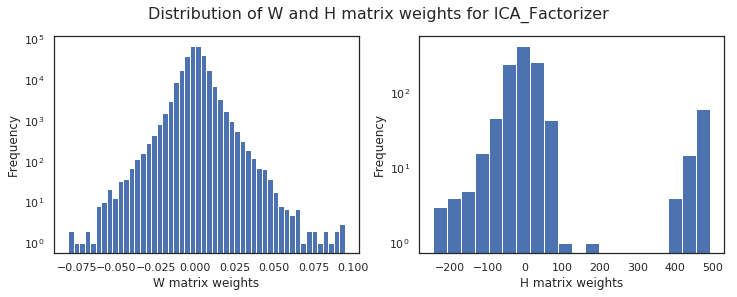

/home/ipoole/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


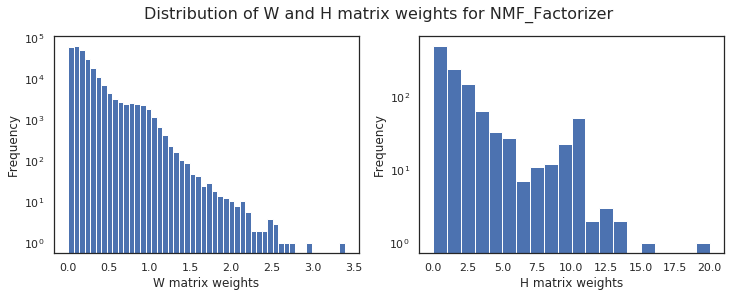

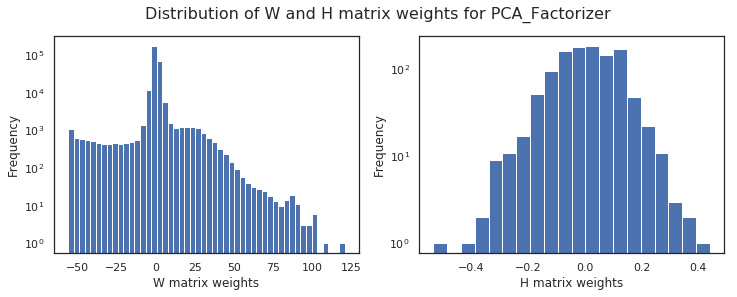

In [26]:
def plot_matrix_weight_distributions(facto):
    facto.fit(expression_matrix)
    W = facto.get_W()
    H = facto.get_H()

    plt.figure(figsize=(12, 4))
    plt.suptitle("Distribution of W and H matrix weights for %s" %type(facto).__name__, size=16)
    plt.subplot(1,2,1)
    plt.hist(W.ravel(), bins=50, log=True)
    plt.xlabel("W matrix weights")
    plt.ylabel("Frequency")
    plt.subplot(1,2,2)
    plt.hist(H.ravel(), bins=20, log=True)
    plt.ylabel("Frequency")
    plt.xlabel("H matrix weights")
    plt.show()
    
facto = ICA_Factorizer(n_components=14)
plot_matrix_weight_distributions(facto)

facto = NMF_Factorizer(n_components=14)
plot_matrix_weight_distributions(facto)

facto = PCA_Factorizer(n_components=14)
plot_matrix_weight_distributions(facto)




## Let's find some influential genes!

In [27]:
# Read in the k=14 metagenes matrix found by BIODICA

biodica_matrix_file = "../Factors/S_HGSOC_Protein_Expression_ica_numerical.txt_6.num"
biod_ica = np.loadtxt(biodica_matrix_file)
biod_ica.shape

(19730, 6)

In [28]:
from sklearn import preprocessing

all_genes = expression_matrix.shape[0]
n_genes = all_genes   # trim for speed while we develop
n_comps = 6
expression_matrix[:n_genes,:]

gene_ENSG_ids = expression_df.index.values[:n_genes]
gene_symbols = [ensgDict[ensg]['symbol'] for ensg in gene_ENSG_ids]
nmf_facto = NMF_Factorizer(n_components=n_comps, max_iter=1000)
ica_facto = ICA_Factorizer(n_components=n_comps)
pca_facto = PCA_Factorizer(n_components=n_comps)

V = expression_matrix
nmf_facto.fit(V)
print("NMF fit done")
ica_facto.fit(V)
print("ICA fit done")
pca_facto.fit(V)
print("PCA fit done")

/home/ipoole/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


NMF fit done
ICA fit done
PCA fit done


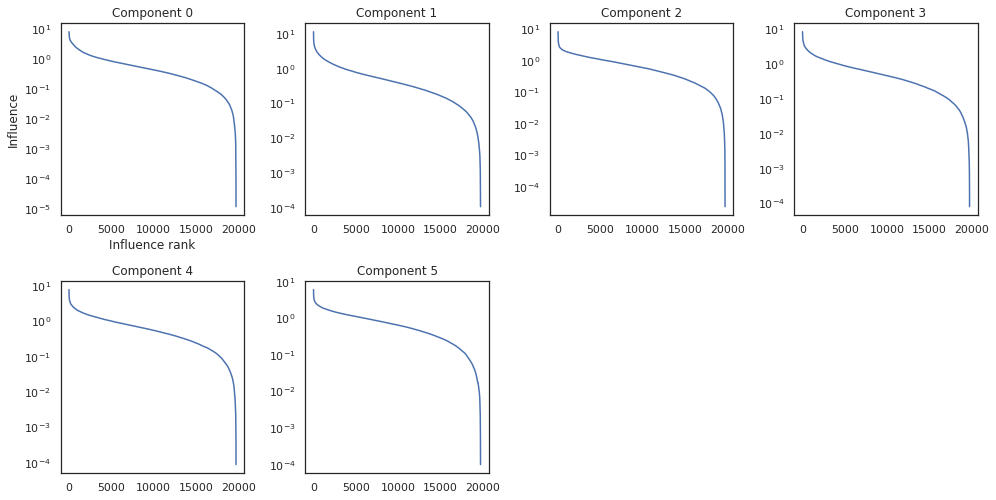

In [29]:
def show_component_ranked_plots(metagene_matrix):
    assert metagene_matrix.shape == (n_genes, n_comps)
    fig = plt.figure(figsize=(14,14))

    for ci in range(n_comps):
        plt.subplot(4,4,ci+1)
        metagene = metagene_matrix[:, ci]
        #influence = abs(metagene)
        influence = metagene
        gixpairs = zip(gene_symbols, influence)
        gixpairs = sorted(gixpairs, key=lambda p: -p[1])
        ranked_symbols, ranked_influence,  = zip(*gixpairs)
        plt.plot(ranked_influence)
        plt.yscale('log')
        if ci == 0:
            plt.xlabel('Influence rank')
            plt.ylabel('Influence')
        fig.tight_layout() 
        plt.title('Component %d' % ci)
    plt.show()    


show_component_ranked_plots(abs(biod_ica))

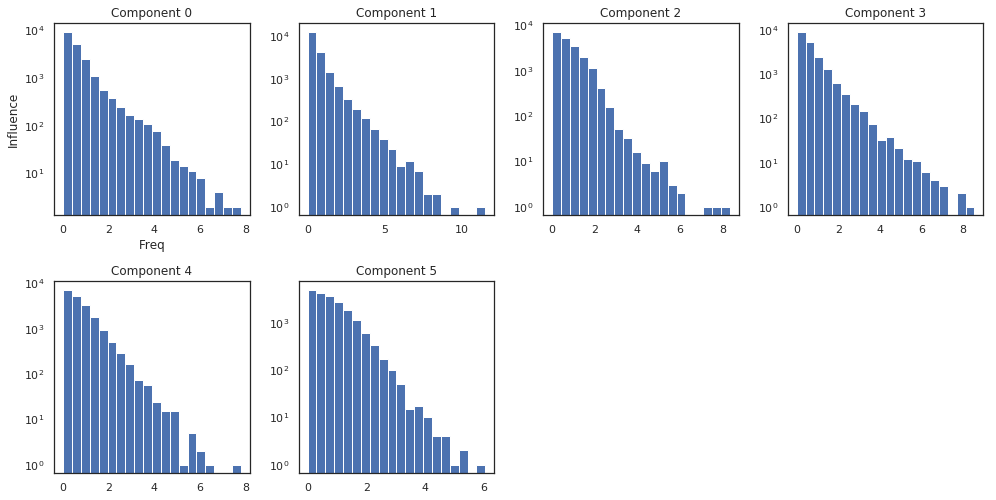

In [30]:
def show_component_distributions(metagene_matrix):
    assert metagene_matrix.shape == (n_genes, n_comps)
    fig = plt.figure(figsize=(14,14))

    for ci in range(n_comps):
        plt.subplot(4,4,ci+1)
        metagene = metagene_matrix[:, ci]
        #influence = abs(metagene)
        influence = metagene
        
        plt.hist(influence, bins=20)
        plt.yscale('log')
        if ci == 0:
            plt.xlabel('Freq')
            plt.ylabel('Influence')
        fig.tight_layout() 
        plt.title('Component %d' % ci)
    plt.show()    

show_component_distributions(abs(biod_ica))

In [31]:
def rank_influential_genes(metagene, top_n):
    influence = abs(metagene)
    # influence = metagene
    gixpairs = zip(gene_symbols, influence)
    gixpairs = sorted(gixpairs, key=lambda p: -p[1])
    ranked_symbols, ranked_influence,  = zip(*gixpairs)
    return ranked_symbols[:top_n]      

W = abs(biod_ica)
# W = biod_ica
ranked_genes_by_component = {}
for ci in range(n_comps):
    _genes = rank_influential_genes(W[:,ci], 100)
    ranked_genes_by_component[ci] = _genes
    if True:
        print("Comp. %d: %s" % (ci, ' '.join(_genes)))
    else:
        print("Comp. %d: \n%s\n" % (ci, '\n'.join(_genes)))
        # print("Comp. %d: \n%s\n" % (ci, genes))

Comp. 0: IGLL5 CXCL9 JCHAIN UBD ADAMDEC1 CXCL10 CXCL13 CXCL11 MZB1 HP CD2 SLAMF7 GBP5 CD38 OR2I1P PLA2G2D CCL19 HOXD1 CSAG3 HLA-DQA1 LYZ ADCY8 CD3E CCL5 ZNF683 GZMB GNLY NKG7 IL2RG CD79A FBN3 IRF4 IDO1 CD3D LOC102723407 MAGEA4 MS4A1 CCL8 CCR5 GZMK PRF1 SOX11 TIGIT MMP9 ICOS MAGEA1 GZMA SNX20 CXCR6 CCR2 CD52 CD48 HLA-DQA2 CXCR3 FASLG SH2D1A HLA-DQB1 GBP4 FCN1 GZMH CD7 HLA-DPA1 ZAP70 IL21R SIRPG CD247 C1QB TFEC HLA-DRB5 CTLA4 LTB OASL SLAMF1 CD8A LILRB4 PTPRCAP IL4I1 CYBB C1QA CYP2W1 LILRB2 FPR3 CCL18 GAL3ST3 COL9A3 FYB1 PLEK AL645922.1 TYMP PTPRC CTSW TNFRSF18 XCL2 SASH3 P2RY10 SERPINA1 EDN3 C1QC EOMES PYHIN1
Comp. 1: SFRP2 POSTN EPYC COL11A1 LRRC15 ADH1B COL10A1 STAR FAP COMP GREM1 FABP4 LUM INHBA TENM3 MMP11 NR5A1 ITGBL1 CXCL14 NTM PRRX1 DLK1 MFAP4 THBS2 ASPN BCHE ALPK2 DPT VCAN COLEC11 COL3A1 ALPG TIMP3 CADM3 MOXD1 FN1 ELAPOR1 BARX1 ISM1 ALPP GFRA1 COL5A1 ADIPOQ PRG4 CT45A1 COL5A2 SPDEF CCDC80 IGFL2 PODN GJB1 MMP2 MMP13 COL8A1 NKD2 SSC5D CTHRC1 SVEP1 ADAM12 SLC35D3 PTGER3 OMD LRRN4 S

## Gene enrichment analysis using GOATOOLS

In [32]:
from goatools import obo_parser
from goatools.go_enrichment import GOEnrichmentStudy
import Bio.UniProt.GOA as GOA
import gzip

# Load the Gene Ontology
gene_ontology = go = obo_parser.GODag('../DownloadedResources/go-basic.obo')

# Load the human annotations
c=0
with gzip.open('../DownloadedResources/goa_human.gaf.gz', 'rt') as gaf:
    funcs = {}
    for entry in GOA.gafiterator(gaf):
        c +=1 
        uniprot_id = entry.pop('DB_Object_Symbol')
        funcs[uniprot_id] = entry

../DownloadedResources/go-basic.obo: fmt(1.2) rel(2020-06-01) 47,233 GO Terms


In [33]:
c

502842

In [35]:
# Our population is the set of genes we are analysing

population = [ensgDict[ensg]['symbol'] for ensg in expression_df.index.values]
print("We have %d genes in our population" % len(population))

# Build associations from functional annotations we got from the gaf file
associations = {}
for x in funcs:
    if x not in associations:
        associations[x] = set()
    associations[x].add(str(funcs[x]['GO_ID']))

We have 19730 genes in our population


In [36]:

gea = GOEnrichmentStudy(population, associations, gene_ontology,
                         propagate_counts=True,
                         alpha=0.05,
                         methods=['fdr'])
gea_results_by_component = {}
for ci in range(n_comps):
    study_genes = ranked_genes_by_component[ci]
    gea_results_by_component[ci] = gea.run_study(study_genes)


Load GOEA Gene Ontology Analysis ...
Propagating term counts up: is_a
 93% 18,429 of 19,730 population items found in association

Run GOEA Gene Ontology Analysis: current study set of 100 IDs ... 97%     97 of    100 study items found in association
100%    100 of    100 study items found in population(19730)
Calculating 8,725 uncorrected p-values using fisher
   8,725 GO terms are associated with 18,418 of 19,730 population items
     466 GO terms are associated with     97 of    100 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0006981124644081826
Sample 10 / 500: p-value 0.0003764740061374217
Sample 20 / 500: p-value 0.0006981124644081826
Sample 30 / 500: p-value 0.00015159104496019368
Sample 40 / 500: p-value 0.0022242969799494377
Sample 50 / 500: p-value 0.0004907517840029698
Sample 60 / 500: p-value 0.0017570470224890532
Sample 70 / 500: p-value 7.60472736424023e-05
Sample 80 / 500: p-value 0.001257333726411815
Sample 90 / 500: p-value 0.0008607987181806095
Sample 100 / 500: p-value 0.00025181566515699856
Sample 110 / 500: p-value 9.960001365414334e-05
Sample 120 / 500: p-value 0.00025181566515699856
Sample 130 / 500: p-value 0.0003764740061374217
Sample 140 / 500: p-value 0.005068423720131907
Sample 150 / 500: p-value 0.0005122411637435171
Sample 160 / 500: p-value 0.0008946074162944974
Sample 170 / 500: p-value 0.005068423720131907
Sample 180 / 500: p-value 0.0006981124644081826
Sample 190 / 500

  METHOD fdr:
       8 GO terms found significant (< 0.05=alpha) (  8 enriched +   0 purified): local fdr
      14 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 100 IDs ... 98%     98 of    100 study items found in association
100%    100 of    100 study items found in population(19730)
Calculating 8,725 uncorrected p-values using fisher
   8,725 GO terms are associated with 18,418 of 19,730 population items
     384 GO terms are associated with     98 of    100 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0016534779851534744
Sample 10 / 500: p-value 0.005068423720131907
Sample 20 / 500: p-value 0.0045531169135867855
Sample 30 / 500: p-value 0.001114565734654517
Sample 40 / 500: p-value 0.00025181566515699856
Sample 50 / 500: p-value 0.002457852741732734
Sample 60 / 500: p-value 0.0006981124644081826
Sample 70 / 500: p-value 0.00015159104496019368
Sample 80 / 500: p-value 0.0036747129425932336
Sample 90 / 500: p-value 0.0006648291533454895
Sample 100 / 500: p-value 0.0003774645094378093
Sample 110 / 500: p-value 0.0003764740061374217
Sample 120 / 500: p-value 0.0005253207674539196
Sample 130 / 500: p-value 0.0007023584312596647
Sample 140 / 500: p-value 0.00025181566515699856
Sample 150 / 500: p-value 0.005068423720131907
Sample 160 / 500: p-value 0.001114565734654517
Sample 170 / 500: p-value 0.0016239218080333667
Sample 180 / 500: p-value 0.0016239218080333667
Sample 190 / 500:

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
      22 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 100 IDs ... 56%     56 of    100 study items found in association
100%    100 of    100 study items found in population(19730)
Calculating 8,725 uncorrected p-values using fisher
   8,725 GO terms are associated with 18,418 of 19,730 population items
     232 GO terms are associated with     56 of    100 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0010113279642532146
Sample 10 / 500: p-value 0.0006981124644081826
Sample 20 / 500: p-value 0.005068423720131907
Sample 30 / 500: p-value 0.0006744534719405115
Sample 40 / 500: p-value 0.0003764740061374217
Sample 50 / 500: p-value 0.005068423720131907
Sample 60 / 500: p-value 0.0018824150437699613
Sample 70 / 500: p-value 0.0005253207674539196
Sample 80 / 500: p-value 7.60472736424023e-05
Sample 90 / 500: p-value 0.0019128486426037794
Sample 100 / 500: p-value 0.001256490267463906
Sample 110 / 500: p-value 0.0016239218080333667
Sample 120 / 500: p-value 0.0016788615641846149
Sample 130 / 500: p-value 0.005068423720131907
Sample 140 / 500: p-value 0.00025181566515699856
Sample 150 / 500: p-value 0.004111332755367922
Sample 160 / 500: p-value 0.0014887137060316305
Sample 170 / 500: p-value 0.0014443834598466066
Sample 180 / 500: p-value 0.0003764740061374217
Sample 190 / 500: p-

  METHOD fdr:
       1 GO terms found significant (< 0.05=alpha) (  0 enriched +   1 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       9 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 100 IDs ... 88%     88 of    100 study items found in association
100%    100 of    100 study items found in population(19730)
Calculating 8,725 uncorrected p-values using fisher
   8,725 GO terms are associated with 18,418 of 19,730 population items
     426 GO terms are associated with     88 of    100 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008946074162944974
Sample 10 / 500: p-value 0.001114565734654517
Sample 20 / 500: p-value 0.0008946074162944974
Sample 30 / 500: p-value 0.0008946074162944974
Sample 40 / 500: p-value 0.004333475487405034
Sample 50 / 500: p-value 0.0008946074162944974
Sample 60 / 500: p-value 8.961141159885e-05
Sample 70 / 500: p-value 2.543331888448247e-05
Sample 80 / 500: p-value 0.0008946074162944974
Sample 90 / 500: p-value 0.005068423720131907
Sample 100 / 500: p-value 0.0027868330357695534
Sample 110 / 500: p-value 0.0005735645763244201
Sample 120 / 500: p-value 0.0005253207674539196
Sample 130 / 500: p-value 0.0003764740061374217
Sample 140 / 500: p-value 8.1587067500691e-05
Sample 150 / 500: p-value 0.005068423720131907
Sample 160 / 500: p-value 0.0036907091201748613
Sample 170 / 500: p-value 7.60472736424023e-05
Sample 180 / 500: p-value 0.0008946074162944974
Sample 190 / 500: p-value

  METHOD fdr:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 100 IDs ... 88%     88 of    100 study items found in association
100%    100 of    100 study items found in population(19730)
Calculating 8,725 uncorrected p-values using fisher
   8,725 GO terms are associated with 18,418 of 19,730 population items
     409 GO terms are associated with     88 of    100 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00015159104496019368
Sample 10 / 500: p-value 0.0006981124644081826
Sample 20 / 500: p-value 0.0003764740061374217
Sample 30 / 500: p-value 3.0370822019687222e-05
Sample 40 / 500: p-value 0.005068423720131907
Sample 50 / 500: p-value 0.0015361253652184863
Sample 60 / 500: p-value 0.0003764740061374217
Sample 70 / 500: p-value 0.005068423720131907
Sample 80 / 500: p-value 0.005068423720131907
Sample 90 / 500: p-value 0.00011616131054968331
Sample 100 / 500: p-value 0.005068423720131907
Sample 110 / 500: p-value 0.0036907091201748613
Sample 120 / 500: p-value 0.0006331777063539548
Sample 130 / 500: p-value 0.0016239218080333667
Sample 140 / 500: p-value 0.0003764740061374217
Sample 150 / 500: p-value 0.005068423720131907
Sample 160 / 500: p-value 0.00329146860416121
Sample 170 / 500: p-value 7.60472736424023e-05
Sample 180 / 500: p-value 6.9456765734142464e-06
Sample 190 / 500: p

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
      11 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run GOEA Gene Ontology Analysis: current study set of 100 IDs ... 70%     70 of    100 study items found in association
100%    100 of    100 study items found in population(19730)
Calculating 8,725 uncorrected p-values using fisher
   8,725 GO terms are associated with 18,418 of 19,730 population items
     346 GO terms are associated with     70 of    100 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 1.9149072329248042e-05
Sample 10 / 500: p-value 0.0022242969799494377
Sample 20 / 500: p-value 0.005068423720131907
Sample 30 / 500: p-value 0.0008661640447650428
Sample 40 / 500: p-value 7.60472736424023e-05
Sample 50 / 500: p-value 0.005068423720131907
Sample 60 / 500: p-value 0.0003764740061374217
Sample 70 / 500: p-value 0.0003764740061374217
Sample 80 / 500: p-value 0.0036747129425932336
Sample 90 / 500: p-value 0.001114565734654517
Sample 100 / 500: p-value 0.0022242969799494377
Sample 110 / 500: p-value 0.005068423720131907
Sample 120 / 500: p-value 0.002558035718897677
Sample 130 / 500: p-value 0.0008946074162944974
Sample 140 / 500: p-value 0.0004548961860545808
Sample 150 / 500: p-value 0.0003764740061374217
Sample 160 / 500: p-value 0.0012880759377910775
Sample 170 / 500: p-value 0.0006172046910071674
Sample 180 / 500: p-value 0.005068423720131907
Sample 190 / 500: p-v

  METHOD fdr:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): local fdr
       4 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


In [37]:
# Get results into a dataframe per component.  Easiest way is to use routine to write a .tsv file, 
# then read back and filter

gea_results_df_by_component = []
for ci in range(n_comps):
    tsv_name = '../Cache/goa_results_C%d.tsv' % ci
    with open(tsv_name, 'w') as f:
        gea.prt_tsv(f, gea_results_by_component[ci])
    ge_df = pd.read_csv(tsv_name, sep='\t')

    ge_df.rename(columns={'# GO':'GO_ID'}, inplace=True)
    ge_df.set_index('GO_ID', inplace=True)
    ge_df.drop(columns=['NS', 'enrichment', 'p_uncorrected', 'depth'], inplace=True)
    ge_df = ge_df[ge_df['p_fdr'] <= 0.05]
    ge_df['Component'] = ci
    
    gea_results_df_by_component += [ge_df]

In [38]:
# Merge the per-component dataframes into a single one
gea_all_sig_results_df = pd.DataFrame()
gea_all_sig_results_df = gea_all_sig_results_df.append(gea_results_df_by_component)
gea_all_sig_results_df.to_csv('../Cache/gea_all_sig_results.tsv', sep='\t')

In [39]:
qgrid.show_grid(gea_all_sig_results_df)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

## Run-once code following

### Following is run-once code for recovering metadata from the Patch et al paper...

In [ ]:
# Extract age and response group from scraped text file
def extract_metadata_from_crazy_scraped_file(scrape_file):
    with open(scrape_file, 'r') as f:
        l1 = f.readline().strip()
        l2 = f.readline().strip()
    l1_words = l1.split(' ')
    aocs_ids = l1_words[::2]
    aocs_ids = [s.replace('-','_') for s in aocs_ids]
    
    ages = l1_words[1::2]
    response = l2.split(' ')
    assert len(aocs_ids) == len(ages) == len(response) == 80
    # Build a dataframe
    df = pd.DataFrame()
    df['AOCS_ID'] = aocs_ids
    df['Age'] = ages
    df['Response'] = response
    
    df = df.set_index('AOCS_ID')
    df = df.sort_index()
    
    return df

In [40]:
# Enable only if 'AOCS_metadata.csv' is to be re-created
if False:
    metadata_df = extract_metadata_from_crazy_scraped_file('../Data/aocs_raw_figure_e6.txt')
    metadata_df.to_csv('../Data/AOCS_metadata.csv')
    readback_metadata_df = pd.read_csv('../Data/AOCS_metadata.csv', index_col='AOCS_ID')
    readback_metadata_df
    assert len(readback_metadata_df) == 80
    readback_metadata_df

## Run-once code to convert create a protein coding gene only expression file

The original 'AOCS_TPM_VST.csv' contains 57,424 transcripts, many of which are non-codeing.   We wish to work with protein coding genes only.  We proceed as follows:
1. Read AOCS_TPM_VST.csv into a dataframe with ENSG identifiers as index
1. Write a text file listing all ENSG identifiers extracted from AOCS_TPM_VST.csv creating ensg_list.txt
1. Obtain an annotated gene table from [Biomart](https://m.ensembl.org/info/data/biomart/index.html):
   1. Manually (should automate) upload ensg_list.txt
   1. Select attributes of Gene stable ID, Gene name, Gene type, and Gene description; it's Gene type which is important
   1. Export the generated table to 'DownloadedResources/mart_export.txt'
1. Read mart_export.txt into a dataframe with ENSG identifiers as index and filter on Gene type == 'protein_coding'
1. Merge the original full expression dataframe with the filtered dataframe
1. Write out a tab-seperated file 'HGSOC_Protein_Expression.csv' containing GeneENSG as first column with patient expression values in the following 80 columns

The generated HGSOC_Protein_Expression.csv is in a format suitable for direct input to BIODICA and can be used for all other analysis.


In [41]:
if False:
    # Read in original full AOCS spreadsheet
    full_expression_df = pd.read_csv('../Data/AOCS_TPM_VST.csv')
    full_expression_df.set_index('GeneENSG', inplace=True)
    assert len(full_expression_df) == 57914
    assert len(full_expression_df.columns == 80 + 1)
    assert full_expression_df.columns[-1] == 'AOCS_171'
    ensglist = full_expression_df.index.values.tolist()
    with open('../Cache/ensg_list.txt', 'w') as f:
        f.write('\n'.jTrueoin(ensglist))

In [42]:
# This is where you have to do the manual Biomart stuff as described above... then run the following cell

In [43]:
if False:
    # Read in the Biomart created file
    mart_export_df = pd.read_csv('../DownloadedResources/mart_export.txt', sep='\t')
    mart_export_df.set_index('Gene stable ID', inplace=True)
    assert mart_export_df.loc['ENSG00000198804', 'Gene type'] == 'protein_coding'
    
    # Create a dataframe containing only protein coding genes
    mart_export_protein_coding_df = mart_export_df[mart_export_df['Gene type'] == 'protein_coding']

    # Merge with full expression dataframe (only those present in both will be kept)
    expression_protein_coding_df = pd.merge(
        left=full_expression_df, right=mart_export_protein_coding_df, 
        left_index=True, right_index=True)
    expression_protein_coding_df.drop(columns=['Gene name', 'Gene type', 'Gene description'], inplace=True)
    assert len(expression_protein_coding_df.columns) == 80

    # Write the filtered expression matrix to a .csv file
    expression_protein_coding_df.to_csv('../Data/HGSOC_Protein_Expression.csv', index=True, index_label='GeneENSG', sep='\t')
    
    # Read it back and check all in order
    del expression_protein_coding_df
    expression_protein_coding_df = pd.read_csv('../Data/HGSOC_Protein_Expression.csv', sep='\t')
    expression_protein_coding_df.set_index('GeneENSG', inplace=True)
    assert len(expression_protein_coding_df.columns) == 80
    assert len(expression_protein_coding_df) == 19730
    
    # Paranoia: the following specific expression value was manually extracted from the orginal AOCS_TPM_VST.csv,
    # and is compared here to check we haven't somehow scrambled the ordering anywhere!
    assert expression_protein_coding_df.loc['ENSG00000138772', 'AOCS_004'] == 12.6329098049671
    
    del full_expression_df
    

In [ ]:
help(gea)